### Import

In [12]:
import sys; sys.path.insert(0, '..')
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from df_utils import df_wrapper, get_timestamp_and_pose, POSE_MAP, combine_dataframes
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical

### Define data

In [2]:
@dataclass
class training_class:
    csv_file: str
    annot_file: str

@dataclass
class testing_class:
    csv_file: str
    annot_file: str

training_files = {
    "Martin": training_class("../../data/train_data/martin_train_3_030221.csv", 
                            "../../data/annotation/training/martin_train_3_030221.txt"),
    "Simon": training_class("../../data/train_data/simon_train_3_080221.csv",
                            "../../data/annotation/training/simon_train_3_080221.txt"),
    "Jonas": training_class("../../data/train_data/jonas_train_3_080221.csv",
                            "../../data/annotation/training/jonas_train_3_080221.txt"),
    "Elise": training_class("../../data/train_data/elise_train_3_090221.csv",
                            "../../data/annotation/training/elise_train_3_090221.txt"),
}

testing_file = testing_class("../../data/test_data/martin_test_3_040221.csv",
                             "../../data/annotation/testing/martin_test_3_040221.txt")

AMOUNT_OF_SENSORS = 3

### Datapreparation

In [3]:
knn_train = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    stamped_poses = get_timestamp_and_pose(training_files[key].annot_file, POSE_MAP)
    elem.align_poses(stamped_poses)
    knn_train.append(elem)

y_train = pd.concat([x.df['Pose'] for x in knn_train])

knn_test = df_wrapper(testing_file.csv_file)
knn_test.concat_sensor_data(AMOUNT_OF_SENSORS)
test_stamped_poses = get_timestamp_and_pose(testing_file.annot_file, POSE_MAP)
knn_test.align_poses(test_stamped_poses)
y_test = knn_test.df["Pose"]
y_test.index = [i for i in range(len(y_test))]

../df_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../df_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../df_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

### Visualisation

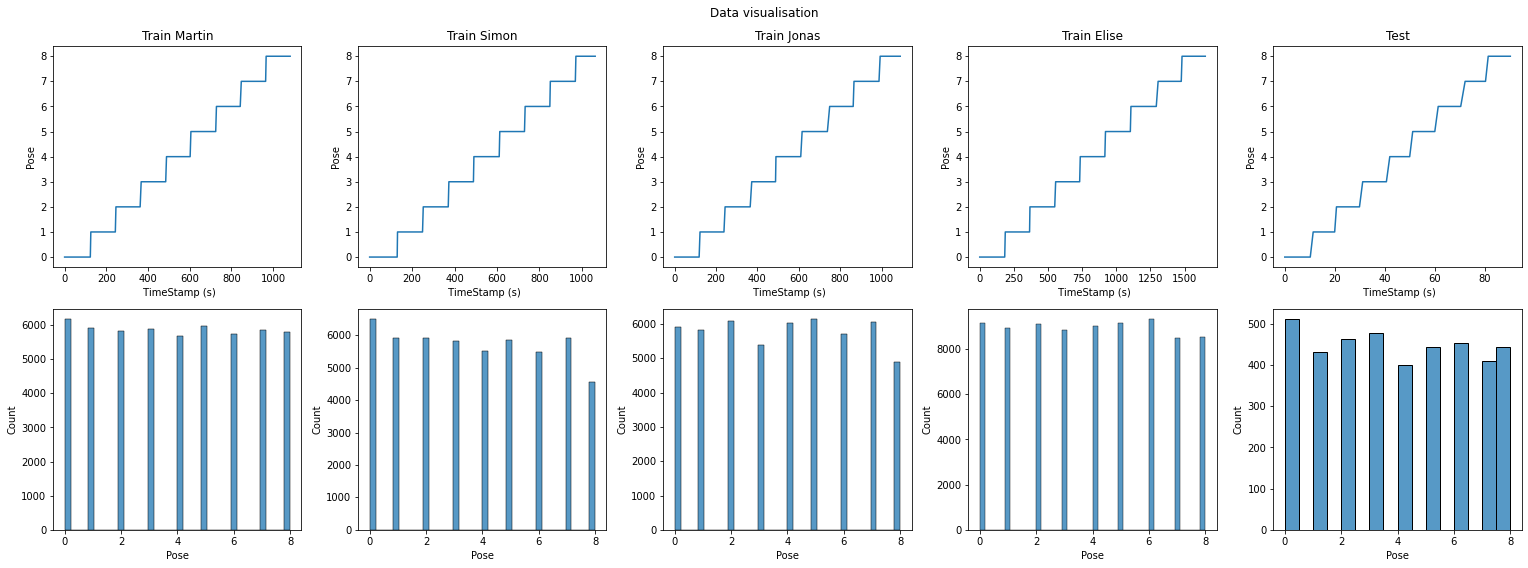

In [4]:
cols = []
height=8
width=(height/1.5)*len(knn_train)
fig, axes = plt.subplots(2, len(knn_train)+1, figsize=(width, height))
fig.suptitle('Data visualisation')
for i in range(len(knn_train)):
    sns.lineplot(ax=axes[0, i], data=knn_train[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=knn_train[i].df["Pose"])
    cols.append('Train')    
for i, key in enumerate(training_files):
    cols[i] += f' {key}'
sns.lineplot(ax=axes[0, len(knn_train)], data=knn_test.df, x=" TimeStamp (s)", y='Pose')
sns.histplot(ax=axes[1, len(knn_train)], data=y_test)
cols.append('Test')
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

### Adjust dataframes

In [5]:
x_train = combine_dataframes([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in knn_train])
x_test = knn_test.df.drop([' TimeStamp (s)', 'Pose'], axis=1) 

x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(236946, 48)
(236946,)
(4039, 48)
(4039,)


### Add scaler

In [9]:
scaler = MinMaxScaler()
scaler.fit(x_train_numpy)
x_train_numpy = scaler.transform(x_train_numpy)
x_test_numpy = scaler.transform(x_test_numpy)

y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)

### Hyperparams

In [10]:
EPOCH = 50
BATCH_SIZE = 500
LR = 0.00005
DROPOUT_RATE1 = 0.4
DROPOUT_RATE2 = 0.9
ACTIVATION1 = 'relu'
ACTIVATION2 = 'softmax'
OPTIM = Adam(learning_rate=LR)

### Model

In [13]:
model = Sequential()
model.add(Dense(48, activation=ACTIVATION1))
model.add(Dropout(rate=DROPOUT_RATE1))
model.add(Dense(24, activation=ACTIVATION1))
model.add(Dropout(rate=DROPOUT_RATE2))
model.add(Dense(9, activation=ACTIVATION2))

model.compile(optimizer=OPTIM, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

### Fit the model

In [ ]:
model.fit(x=x_train_numpy, y=y_train, batch_size=BATCH_SIZE, validation_data=(x_test_numpy, y_test), shuffle=True, epochs=EPOCH)


Epoch 1/50
474/474 [==============================] - 2s 3ms/step - loss: 3.0263 - accuracy: 0.1088 - val_loss: 2.1987 - val_accuracy: 0.0087
Epoch 2/50
474/474 [==============================] - 1s 3ms/step - loss: 2.3100 - accuracy: 0.1145 - val_loss: 2.1907 - val_accuracy: 0.1072
Epoch 3/50
474/474 [==============================] - 1s 3ms/step - loss: 2.2238 - accuracy: 0.1227 - val_loss: 2.1762 - val_accuracy: 0.1079
Epoch 4/50
474/474 [==============================] - 1s 2ms/step - loss: 2.1986 - accuracy: 0.1228 - val_loss: 2.1506 - val_accuracy: 0.2166
Epoch 5/50
474/474 [==============================] - 1s 3ms/step - loss: 2.1799 - accuracy: 0.1255 - val_loss: 2.1243 - val_accuracy: 0.2236
Epoch 6/50
474/474 [==============================] - 1s 3ms/step - loss: 2.1600 - accuracy: 0.1270 - val_loss: 2.0998 - val_accuracy: 0.2236
Epoch 7/50
474/474 [==============================] - 1s 2ms/step - loss: 2.1349 - accuracy: 0.1289 - val_loss: 2.0707 - val_accuracy: 0.2248
Epoch 

### Visualise the loss

<AxesSubplot:>

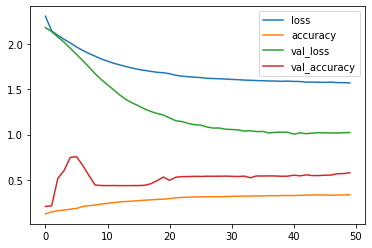

In [ ]:
history = pd.DataFrame(model.history.history)
history.plot()

### Predict

2332
% of corrects: 57.737063629611285


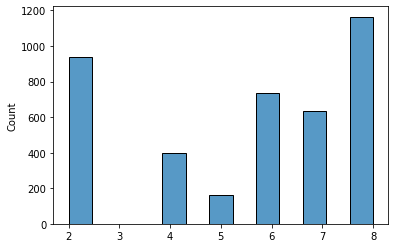

In [ ]:
predictions = model.predict(x_test_numpy)
predictions_final = []  
y_test_arr = []
for index in range(len(predictions)):
    predictions_final.append(predictions[index].argmax())
    y_test_arr.append(y_test[index].argmax())

number_of_corrects = 0
for i in range(len(predictions_final)):
    if(predictions_final[i] == y_test_arr[i]):
        number_of_corrects += 1
print(number_of_corrects)
print("% of corrects: {}".format(number_of_corrects/len(predictions_final)*100))

### Visualise prediction

<AxesSubplot:xlabel='x', ylabel='y'>

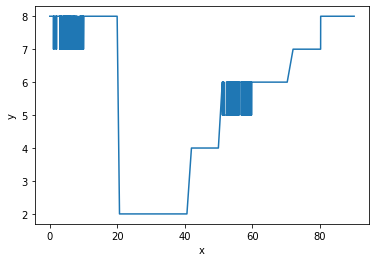

In [ ]:
sns.histplot(predictions_final)
df_predict = pd.DataFrame({'x': knn_test.df[' TimeStamp (s)'],'y':predictions_final})
sns.lineplot(data=df_predict,x='x',y='y')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>